
# Predicting Accidents in New York City
## Capstone Project 1
### Gene Hopping
### Springboard Data Science Career Track
## Part 3: Model generation
# Contents

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, lars_path
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import scipy.stats as stats
from datetime import date, time, timedelta, datetime
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle

In [2]:
#read in the data frames
accident_df = pd.read_csv('accident_df.csv')
#read in the traffic volume dataframe
volume_df = pd.read_csv('final_volume_counts.csv')

/Users/gene/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Accident data

In [3]:
accident_df.head()

,datetime,date,time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,...,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,unique_key,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,datetime.1
0,2019-04-16 00:00:00,2019-04-16 00:00:00,0:00,MANHATTAN,10010,40.737885,-73.98091,"(40.737885, -73.98091)",2 AVENUE,EAST 23 STREET,...,NaN,NaN,NaN,4116367,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16 00:00:00
1,2019-04-16 00:00:00,2019-04-16 00:00:00,0:00,QUEENS,11354,40.762756,-73.82261,"(40.762756, -73.82261)",PARSONS BOULEVARD,38 AVENUE,...,NaN,NaN,NaN,4115878,Sedan,Box Truck,NaN,NaN,NaN,2019-04-16 00:00:00
2,2019-04-16 00:00:00,2019-04-16 00:00:00,0:00,QUEENS,11367,40.729404,-73.82282,"(40.729404, -73.82282)",NaN,NaN,...,NaN,NaN,NaN,4115808,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16 00:00:00
3,2019-04-16 00:00:00,2019-04-16 00:00:00,0:00,QUEENS,11413,40.665485,-73.75374,"(40.665485, -73.75374)",SOUTH CONDUIT AVENUE,224 STREET,...,NaN,NaN,NaN,4115916,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,2019-04-16 00:00:00
4,2019-04-16 00:00:00,2019-04-16 00:00:00,0:00,NaN,NaN,40.810173,-73.95117,"(40.810173, -73.95117)",WEST 125 STREET,NaN,...,NaN,NaN,NaN,4116309,Station Wagon/Sport Utility Vehicle,Taxi,NaN,NaN,NaN,2019-04-16 00:00:00


In [4]:
accident_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293105 entries, 0 to 1293104
Data columns (total 31 columns):
datetime                         1293105 non-null object
date                             1293105 non-null object
time                             1293105 non-null object
borough                          1010383 non-null object
zip_code                         1010225 non-null object
latitude                         1293105 non-null float64
longitude                        1293105 non-null float64
location                         1293105 non-null object
on_street_name                   1060568 non-null object
cross_street_name                887188 non-null object
off_street_name                  170677 non-null object
number_of_persons_injured        1293090 non-null float64
number_of_persons_killed         1293077 non-null float64
number_of_pedestrians_injured    1293105 non-null int64
number_of_pedestrians_killed     1293105 non-null int64
number_of_cyclist_injured       

Many features were imported as the generic 'object' type. First, set the index to datetime and then create a new dataframe be reampling data by hour

In [5]:
accident_df = accident_df.set_index(pd.DatetimeIndex(accident_df['datetime']))
accident_hourly_df = pd.DataFrame(accident_df['date'].resample('H').count())
accident_hourly_df.head()

,date
datetime,
2012-07-01 00:00:00,15
2012-07-01 01:00:00,11
2012-07-01 02:00:00,14
2012-07-01 03:00:00,17
2012-07-01 04:00:00,7


In [6]:
#will need to rename accident count column. Add in day of the week for convenience
accident_hourly_df['day_of_week'] = accident_hourly_df.index.dayofweek
accident_hourly_df.head()

,date,day_of_week
datetime,,
2012-07-01 00:00:00,15,6
2012-07-01 01:00:00,11,6
2012-07-01 02:00:00,14,6
2012-07-01 03:00:00,17,6
2012-07-01 04:00:00,7,6


In [7]:
#sort out the columns titles.
accident_hourly_df.reset_index(level=0, inplace=True)
accident_hourly_df = accident_hourly_df.rename(columns={'date':'accidents'})
accident_hourly_df.head()


,datetime,accidents,day_of_week
0,2012-07-01 00:00:00,15,6
1,2012-07-01 01:00:00,11,6
2,2012-07-01 02:00:00,14,6
3,2012-07-01 03:00:00,17,6
4,2012-07-01 04:00:00,7,6


In [8]:
#mean_accident_hour_df = pd.DataFrame(accident_hourly_df['accidents'].groupby([accident_hourly_df['day_of_week'], \
 #                               accident_hourly_df['datetime']]).mean())
#mean_accident_hour_df.head()

# Volume data

In [9]:
volume_df = volume_df.rename(columns={'count':'volume'})
volume_df['datetime'] = volume_df['datetime'].astype('datetime64')
volume_df.head()

,datetime,date,time,volume
0,2014-09-13 00:00:00,2014-09-13,00:00:00,22709
1,2014-09-13 01:00:00,2014-09-13,01:00:00,16322
2,2014-09-13 02:00:00,2014-09-13,02:00:00,12008
3,2014-09-13 03:00:00,2014-09-13,03:00:00,9937
4,2014-09-13 04:00:00,2014-09-13,04:00:00,11198


In [10]:
#Visualizing overlap of data
#perform outer join to keep all  data. match on datetime.
overlap_vol_df = volume_df[['date', 'time', 'volume']].copy()
overlap_vol_df['vol_present'] = np.where(overlap_vol_df['volume'] >=5, 1, 0)

In [11]:
len(overlap_vol_df), overlap_vol_df.vol_present.sum()

(7944, 7810)

In [12]:
overlap_vol_df.tail()

,date,time,volume,vol_present
7939,2018-04-15,19:00:00,25500,1
7940,2018-04-15,20:00:00,22073,1
7941,2018-04-15,21:00:00,18295,1
7942,2018-04-15,22:00:00,14946,1
7943,2018-04-15,23:00:00,24938,1


# Joining Data

In [13]:
accident_hourly_df.head()

,datetime,accidents,day_of_week
0,2012-07-01 00:00:00,15,6
1,2012-07-01 01:00:00,11,6
2,2012-07-01 02:00:00,14,6
3,2012-07-01 03:00:00,17,6
4,2012-07-01 04:00:00,7,6


In [14]:
#perform inner join to keep only overlapping data. match on datetime.
accident_merge = pd.merge(volume_df,
                         accident_hourly_df[['accidents']],
                            left_on=volume_df['datetime'],
                            right_on=accident_hourly_df['datetime'],
                            how='inner')

In [15]:
accident_merge.head()

,key_0,datetime,date,time,volume,accidents
0,2014-09-13 00:00:00,2014-09-13 00:00:00,2014-09-13,00:00:00,22709,17
1,2014-09-13 01:00:00,2014-09-13 01:00:00,2014-09-13,01:00:00,16322,21
2,2014-09-13 02:00:00,2014-09-13 02:00:00,2014-09-13,02:00:00,12008,10
3,2014-09-13 03:00:00,2014-09-13 03:00:00,2014-09-13,03:00:00,9937,7
4,2014-09-13 04:00:00,2014-09-13 04:00:00,2014-09-13,04:00:00,11198,15


In [16]:
#check lengths
len_accident_merge = len(accident_merge)
len_vol = len(volume_df)
len_accident = len(accident_hourly_df)
print(f'Length of accident dataframe: {len_accident}\nLength of volume dataframe: {len_vol}\
\nLength of merged dataframe: {len_accident_merge}')

Length of accident dataframe: 59544
Length of volume dataframe: 7944
Length of merged dataframe: 7944


Clean the above dataframe up to contain just volume, date, time and number of accidents. This is the base data used for the model building.

In [17]:
#Select columns to keep in final df - want date and time so can split time into dummy variables
accident_reg_df = accident_merge[['volume', 'date', 'time', 'accidents']]
merged_by_hour = accident_reg_df.copy()
accident_reg_df.head()
accident_volume_df = accident_reg_df.copy()

In [18]:
#write dataframe to disk

accident_reg_df.to_csv(path_or_buf='accident_reg_df.csv')

Text(0, 0.5, 'Accidents')

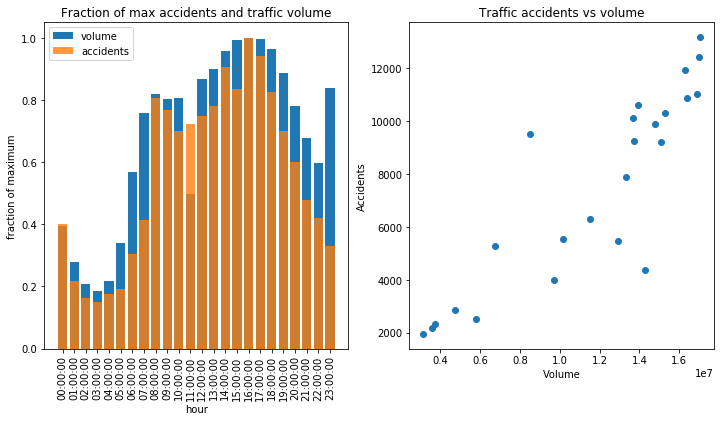

In [19]:
#look at both volume and accidents summed for each hour of the day. Divide by max to
# get faction max value so can see if have same general trend
summed_by_hour = merged_by_hour.groupby(['time']).sum()

#plt.scatter(summed_by_hour.volume, summed_by_hour.accidents)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.bar(summed_by_hour.index, summed_by_hour.volume/summed_by_hour.volume.max(), label='volume')
plt.bar(summed_by_hour.index, summed_by_hour.accidents/summed_by_hour.accidents.max(), alpha=0.8, \
        label='accidents')
plt.title('Fraction of max accidents and traffic volume')
plt.xlabel('hour')
plt.ylabel('fraction of maximum')
_ = plt.xticks(rotation=90)
plt.legend()
plt.subplot(1,2,2)
_ = plt.scatter(summed_by_hour.volume, summed_by_hour.accidents)
plt.title('Traffic accidents vs volume')
plt.xlabel('Volume')
plt.ylabel('Accidents')

Due to the orders of magnitude difference between accidents and number of cars on the road, we used the metric 'fraction max X' to adjust the values to be on the same scale. Data was summed for each hour, irrespective of the day. The bar plot on the left shows the bimodal distribution seen with each distribution, and the same general trend. When plotted against each other, there appears to be a linear relationship between the number of cars on the road and the number of accidents. There are some outliers, however, so let's investigate whether these are imply just outliers, or indicate increased risk of accidents.

In [20]:
#Want to build in 24 dummy variables for the regression to add the hour of the day as a feature
#to the regression
dum = pd.get_dummies(accident_reg_df['time'])
accident_reg_df = pd.concat([accident_reg_df, dum], axis=1) 
accident_reg_df = accident_reg_df.drop('time', axis=1)

In [21]:
accident_reg_df.date = accident_reg_df.date.astype('datetime64')
accident_reg_df.head()
#accident_reg_df.info()

,volume,date,accidents,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,22709,2014-09-13,17,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16322,2014-09-13,21,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12008,2014-09-13,10,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9937,2014-09-13,7,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11198,2014-09-13,15,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#create timedelta column
min_date = accident_reg_df.date.min()
accident_reg_df['date'] = (accident_reg_df['date'] - \
                                           min_date).dt.days.astype(int)
accident_reg_df.to_csv(path_or_buf='accident_reg_df.csv')
accident_reg_df.head()


,volume,date,accidents,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,22709,0,17,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16322,0,21,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12008,0,10,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9937,0,7,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11198,0,15,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#  Linear Regression Model
1. volume vs accident by day
2. volume vs accident by hour by day
3. volume vs accident by hour no day
4. volume vs accident

In [23]:
accident_reg_df.head()
vol_date_acc_df = accident_reg_df[['volume', 'date', 'accidents']]
vol_date_acc_df.head()

,volume,date,accidents
0,22709,0,17
1,16322,0,21
2,12008,0,10
3,9937,0,7
4,11198,0,15


In [24]:
X1 = vol_date_acc_df.drop('accidents', axis=1)
y1 = vol_date_acc_df[['accidents']]

In [25]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=27)

In [26]:
reg = LinearRegression()
reg.fit(X1_train, y1_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
cv_results = cross_val_score(reg, X1_train, y1_train, cv=5)
cv_results

array([0.11457365, 0.0831986 , 0.12028851, 0.10631054, 0.09329401])

In [28]:
print(f'Average cross_val_score is {cv_results.mean()}')

Average cross_val_score is 0.10353306124870507


In [29]:
X1_score = reg.score(X1_train, y1_train)

The number of cars on the road by itself is not a good predictor of traffic accidents.


In [30]:
#We want to predict number of accidents, so remove that column from the df
y2 = accident_reg_df[['accidents']]
X2 = accident_reg_df.drop('accidents', axis=1)


In [31]:
X2.head()

,volume,date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,22709,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16322,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12008,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9937,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11198,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
#Split the data
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=27)

In [33]:
reg = LinearRegression(fit_intercept=False)
m1 = reg.fit(X2_train,y2_train)

# save the model to disk
filename = 'linreg.sav'
pickle.dump(m1, open(filename, 'wb'))

cv_results = cross_val_score(reg, X2_train, y2_train, cv=5)
cv_results

array([0.63406032, 0.63730188, 0.6554138 , 0.63480233, 0.65504819])

In [34]:
X2_score = reg.score(X2_test, y2_test)


In [35]:
print(f'Scores: X1:{X1_score}, X2:{X2_score}')

Scores: X1:0.10573125225216173, X2:0.6568088735553934


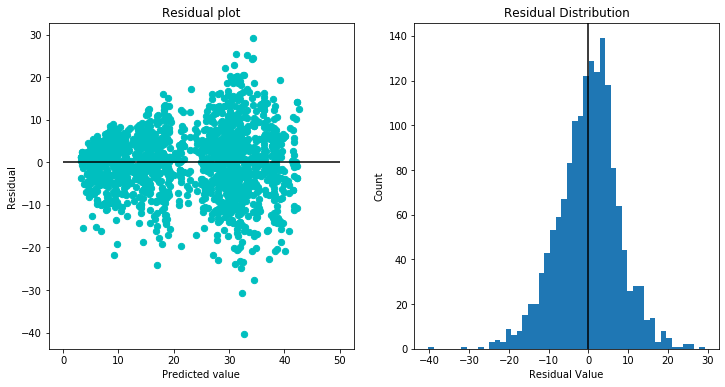

In [36]:
#Residual plot
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
_ = plt.scatter(reg.predict(np.array(X2_test)), reg.predict(np.array(X2_test)) - np.array(y2_test), \
                                                       c='c', s = 40)
plt.hlines(y=0, xmin=0, xmax=50)
plt.title('Residual plot')
plt.ylabel('Residual')
plt.xlabel('Predicted value')
plt.subplot(1,2,2)
_ = plt.hist(reg.predict(np.array(X2_test)) - np.array(y2_test), bins=50)
_ = plt.axvline(0, color='k')
plt.title('Residual Distribution')
plt.ylabel('Count')
plt.xlabel('Residual Value')
plt.savefig('qq_residuals.png')


There pattern of residuals around 0 does not appear to be completely random, indicating some heteroscedasticity. The histogram appears to have some left skew, but appears somewhat normal. We will perform regression with the statsmodels package to report out the statistics.

In [37]:
#Linear regression with statsmodel
from statsmodels.formula.api import ols
m2 = sm.OLS(y2_train, X2_train).fit()
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:              accidents   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     462.9
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        21:23:23   Log-Likelihood:                -22364.
No. Observations:                6355   AIC:                         4.478e+04
Df Residuals:                    6329   BIC:                         4.495e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
volume      1.806e-05   3.04e-06      5.942      0.0

Note warning 2 above - the analyses indicate that there could be strong multicolinearity. This may be a result of the dummy variable trap. This results when two or more variables are highly correlated. In our case, this is representing the hour of the day as dummy variables - 24 of them!

In [38]:
#Calc MSE

metrics.mean_squared_error(y2_test, reg.predict(X2_test))

60.105360036257146

In [39]:
X2_train.head()

,volume,date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
7598,8481,1274,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4462,9896,765,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7236,7734,1226,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3311,9730,435,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
231,46526,9,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [40]:
y2_test.head()

,accidents
806,29
3169,4
6789,21
2212,2
7547,32


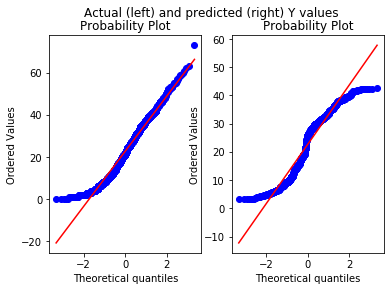

In [41]:
#QQ plot
predictions = m2.get_prediction(X2_test)
actual_data = y2_test['accidents']
data = predictions.summary_frame()
plt.subplot(1,2,1)
plt.suptitle('Actual (left) and predicted (right) Y values')
stats.probplot(actual_data, dist='norm', plot=plt)
plt.subplot(1,2,2)
stats.probplot(data['mean'], dist='norm', plot=plt)
plt.show()

Now that we have established that a linear regression is a suitable model for the traffic accident data, we can perform lasso regularization to select important features of the dataset and shrink the less important ones. This will simplify our model and help us answer the question 'what time of day are you most likely to get into a car accident'.

# Lasso Regression

In [42]:
#scaler = StandardScaler()
#names= X2.columns
#X2 = scaler.fit_transform(X2)

In [43]:
# Create a function called lasso,
def lasso(alphas):
    '''
    Enter a list of alphas. Outputs a dataframe containing the coefficients of lasso 
    regressions for each alpha.
    '''
    # Create an empty data frame
    coef = pd.DataFrame()
    
    # Create a column of feature names
    coef['Feature Name'] = X2.columns
    
    # For each alpha value in the list of alpha values,
    for alpha in alphas:
        # Create a lasso regression with that alpha value,
        lasso = Lasso(alpha=alpha)
        lasso.fit(X2, y2) #fit regression
        
        # Create a column name for that alpha value
        column_name = 'Alpha = %f' % alpha

        # Create a column of coefficient values
        coef[column_name] = lasso.coef_
        
    # Return the dataframe 
    return coef

In [44]:
df = pd.DataFrame(lasso([.0001, .25, .5]))
df

,Feature Name,Alpha = 0.000100,Alpha = 0.250000,Alpha = 0.500000
0,volume,0.000019,0.000070,0.000108
1,date,0.004179,0.005127,0.005839
2,00:00:00,-9.453111,-0.927986,-0.000000
3,01:00:00,-16.695991,-7.863160,-0.000000
4,02:00:00,-18.730889,-9.714377,-1.395630
5,03:00:00,-19.331563,-10.248145,-1.879153
6,04:00:00,-18.262614,-9.270656,-0.970349
7,05:00:00,-17.785682,-9.113941,-1.054111
8,06:00:00,-13.542419,-5.471910,-0.000000
9,07:00:00,-9.273115,-1.700582,-0.000000


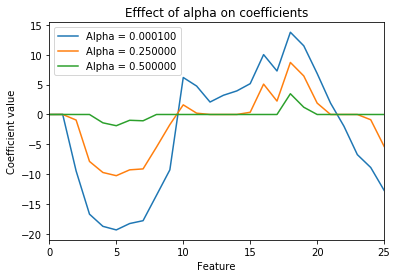

In [92]:
df.plot()
plt.title('Efffect of alpha on coefficients')
plt.xlabel('Feature')
plt.ylabel('Coefficient value')
plt.savefig('lasso_alphas.png')

Regularization shrinks unimportant factors, and leaves us with the most important features for minimizing the loss function. Here we see that negative values for columns 4:7 and positive values for columns 18 and 19.

In [46]:
reg3 = Lasso(alpha=.25)
reg3.fit(X2_train, y2_train)
cv_results = cross_val_score(reg3, X2_train, y2_train, cv=5)
cv_results


array([0.45526341, 0.45583526, 0.48052536, 0.45565887, 0.46174586])

In [47]:
metrics.mean_squared_error(y2_test, reg3.predict(X2_test))

91.9886195934405

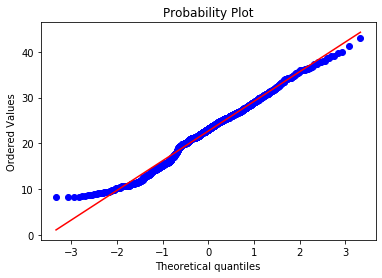

In [48]:
#QQ plot
predictions = reg3.predict(X2_test)

stats.probplot(predictions, dist='norm', plot=plt)

plt.show()

In [49]:
len(predictions)

1589

In [50]:
#Laaso regularization with statsmodel

m3 = sm.OLS(y2_train, X2_train).fit_regularized(method='elastic_net', alpha=0.25, \
        L1_wt=1, refit=True)
print(m3.summary())

                            OLS Regression Results                            
Dep. Variable:              accidents   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     379.2
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        21:23:27   Log-Likelihood:                -23840.
No. Observations:                6355   AIC:                         4.771e+04
Df Residuals:                    6342   BIC:                         4.780e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
volume         0.0001   3.25e-06     32.327      0.0

/Users/gene/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/gene/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/gene/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/gene/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [51]:
np.array(X2_train, dtype='float')



array([[8.4810e+03, 1.2740e+03, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [9.8960e+03, 7.6500e+02, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [7.7340e+03, 1.2260e+03, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [0.0000e+00, 5.4800e+02, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0300e+02, 5.4200e+02, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.8831e+04, 7.9400e+02, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

Talked about regression of traffic volume and accidents only without the hourly compnent

# Poisson Regression

Poisson regression is appropriate for count data where the mean and the variance of the data is the same.

In [52]:
m = accident_reg_df.accidents.mean()
v = (abs(accident_reg_df.accidents - accident_reg_df.accidents. mean())**2).mean()
print(f'Mean:{m}, Variance:{v}')


Mean:22.536002014098692, Variance:185.9803252044263


In [53]:
X2_train.head()

,volume,date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
7598,8481,1274,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4462,9896,765,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7236,7734,1226,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3311,9730,435,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
231,46526,9,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [54]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
m4 = sm.GLM(y2_train, X2_train, family=sm.families.Poisson()).fit()

In [55]:
#Print the training summary.
print(m4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              accidents   No. Observations:                 6355
Model:                            GLM   Df Residuals:                     6329
Model Family:                 Poisson   Df Model:                           25
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24378.
Date:                Mon, 02 Dec 2019   Deviance:                       18950.
Time:                        21:23:28   Pearson chi2:                 1.86e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
volume      7.364e-07   7.04e-08     10.459      0.0

A requirement of a Poisson distribution is that the variance is equal to the mean. For this to be true above, the chi2 value should be close to one. Instead we may be able to use negative bionomial regression. 

# Negative Bionomial Regression

In [56]:
#For negative bionomial regression, add array of lambda values from poisson regression
#to the training dataset
X2_train['X2_lambda'] = m4.mu 
X2_train.head()

/Users/gene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,volume,date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,X2_lambda
7598,8481,1274,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,39.477346
4462,9896,765,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,16.822409
7236,7734,1226,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,32.294840
3311,9730,435,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,12.002082
231,46526,9,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,29.415127


In [57]:
#temporarily add the accident values to calculate
#Now contrive the value of the dependent variable of the OLS regression
#will first add the y2_train values to X2_train
X2_train['accidents'] = y2_train.copy()
X2_train['AUX_OLS_DEP'] = X2_train.apply(lambda x: ((x['accidents'] - x['X2_lambda'])**2 - \
    x['accidents']) / x['X2_lambda'], axis=1)
#X2_train.drop(columns='accidents', inplace=True)
X2_train.head()

/Users/gene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/gene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,volume,date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,...,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,X2_lambda,accidents,AUX_OLS_DEP
7598,8481,1274,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,39.477346,25,4.675936
4462,9896,765,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,16.822409,10,2.172416
7236,7734,1226,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,32.294840,21,3.300014
3311,9730,435,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,12.002082,11,-0.832842
231,46526,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,29.415127,36,0.250230


In [58]:
aux_ols_results = sm.OLS(X2_train['AUX_OLS_DEP'], X2_train['accidents']).fit()
print(aux_ols_results.params)

accidents    0.070671
dtype: float64


Is the alpha value above statistically significant? If not, variance = mean and we will can not obtain a better fit than the Poisson regression.

In [59]:
#what is the t-value
aux_ols_results.tvalues

accidents    32.458744
dtype: float64

Critical value :
https://goodcalculators.com/student-t-value-calculator/

With a significance level of 0.01 and 6329 degrees of freedom
T-value = 2.33
This is much lower than the alpha t-statistic of  of 32.46
Therefore the alpha value of 0.0707 is statistically significant

In [60]:
#Drop additional columns from trainin set
X2_train.drop(columns=['accidents', 'AUX_OLS_DEP', 'X2_lambda'], inplace=True)

/Users/gene/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [61]:
m5 = sm.GLM(y2_train, X2_train, \
    family=sm.families.NegativeBinomial(alpha=aux_ols_results.params[0])).fit()

In [62]:
print(m5.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              accidents   No. Observations:                 6355
Model:                            GLM   Df Residuals:                     6329
Model Family:        NegativeBinomial   Df Model:                           25
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21858.
Date:                Mon, 02 Dec 2019   Deviance:                       8293.5
Time:                        21:23:30   Pearson chi2:                 7.93e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
volume      9.788e-07   1.23e-07      7.950      0.0

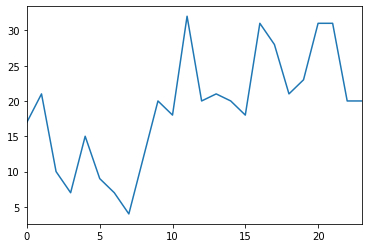

In [63]:
reg1_test_df = accident_reg_df[accident_reg_df.date == 0]
reg1_X = reg1_test_df.drop('accidents', axis=1)
reg1_y = reg1_test_df.accidents
reg1_test_df.accidents.plot()

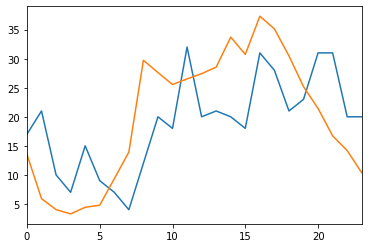

In [64]:
reg1_test_predict = m2.predict(reg1_X)
reg1_test_df.accidents.plot()
_ = plt.plot(reg1_test_df.index, reg1_test_predict)


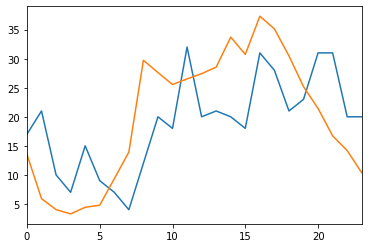

In [65]:

reg1_test_df.accidents.plot()
plt.plot(reg1_test_df.index, reg1_test_predict)

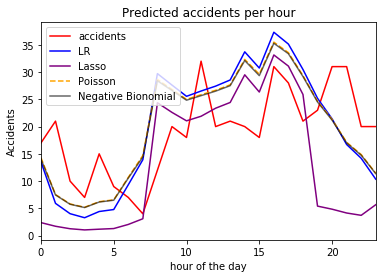

In [88]:
reg2_test_predict = m3.predict(reg1_X)
reg3_test_predict = m4.predict(reg1_X)
reg4_test_predict = m5.predict(reg1_X)
reg1_test_df.accidents.plot(color='r')
_ = plt.plot(reg1_test_df.index, reg1_test_predict, color='blue', label='LR')
_ = plt.plot(reg1_test_df.index, reg2_test_predict,color='purple', label='Lasso')
_ = plt.plot(reg1_test_df.index, reg3_test_predict, color='orange',linestyle='--', label='Poisson')
_ = plt.plot(reg1_test_df.index, reg4_test_predict, color='black', alpha=0.6, label='Negative Bionomial')
plt.legend(loc='upper left')
plt.ylabel('Accidents')
plt.xlabel('hour of the day')
plt.title('Predicted accidents per hour')
plt.savefig('compare_per_hour.png')

In [67]:
#generate output from model using test sample. Assign to variable group by hour and plot
#against actual y-values.

m2_predict = pd.DataFrame(m2.predict(X2_test), columns=['predicted']) # LR
m3_predict = pd.DataFrame(m3.predict(X2_test), columns=['predicted']) # Lasso
m4_predict = pd.DataFrame(m4.predict(X2_test), columns=['predicted']) # Poisson
m5_predict = pd.DataFrame(m5.predict(X2_test), columns=['predicted']) # Negative Bionomial

In [68]:

m3_predict.head()

,predicted
806,34.670636
3169,5.430049
6789,17.746975
2212,6.253183
7547,34.367144


In [69]:
#merge day of week onto index in above series. 
m2_predict_dow = pd.merge(m2_predict.predicted,
                         accident_hourly_df.day_of_week,
                            left_on=m2_predict.index,
                           right_on=accident_hourly_df.index,
                            how='inner').set_index(m2_predict.index).drop('key_0', axis=1)
#could possibly avoid dropping key_0 by passing indexes as labels not series...

In [70]:
m2_predict_dow.head()

,predicted,day_of_week
806,34.670105,4
3169,7.434411,5
6789,21.405049,1
2212,6.086691,0
7547,31.276934,5


In [71]:
#y2_test_dow.head()

In [72]:
accident_volume_df.loc[y2_test.index].groupby('time').sum().accidents

time
00:00:00     954
01:00:00     621
02:00:00     353
03:00:00     404
04:00:00     394
05:00:00     520
06:00:00     757
07:00:00    1185
08:00:00    1667
09:00:00    2393
10:00:00    1960
11:00:00    1626
12:00:00    2151
13:00:00    2083
14:00:00    2110
15:00:00    2785
16:00:00    2805
17:00:00    2514
18:00:00    1830
19:00:00    2061
20:00:00    1398
21:00:00    1304
22:00:00    1084
23:00:00    1178
Name: accidents, dtype: int64

Use the index of y2_train to pull out corresponding rows from the full dataframe. Group by hour and use as the ground truth per hour. Merge the results of the regressions onto this to link time with index and then plot corresponding predictions.

In [73]:
acc_vol_intest_df = accident_volume_df.loc[y2_test.index]
#merge linear regression prediction m2 onto df
m2_predict_dow = pd.merge(acc_vol_intest_df,
                          m2_predict.predicted,
                         left_on=acc_vol_intest_df.index,
                           right_on=m2_predict.index,
                            how='inner').set_index(acc_vol_intest_df.index).drop('key_0', axis=1)
#merge linear regression prediction m3 onto df
m3_predict_dow = pd.merge(acc_vol_intest_df,
                          m3_predict.predicted,
                         left_on=acc_vol_intest_df.index,
                           right_on=m3_predict.index,
                            how='inner').set_index(acc_vol_intest_df.index).drop('key_0', axis=1)
#merge linear regression prediction m4 onto df
m4_predict_dow = pd.merge(acc_vol_intest_df,
                          m4_predict.predicted,
                         left_on=acc_vol_intest_df.index,
                           right_on=m4_predict.index,
                            how='inner').set_index(acc_vol_intest_df.index).drop('key_0', axis=1)
#merge linear regression prediction m4 onto df
m5_predict_dow = pd.merge(acc_vol_intest_df,
                          m5_predict.predicted,
                         left_on=acc_vol_intest_df.index,
                           right_on=m5_predict.index,
                            how='inner').set_index(acc_vol_intest_df.index).drop('key_0', axis=1)

In [74]:
m4_predict_dow.groupby('time').sum().predicted

time
00:00:00     990.334939
01:00:00     568.978687
02:00:00     354.098839
03:00:00     388.048916
04:00:00     394.170401
05:00:00     460.529539
06:00:00     779.331592
07:00:00    1239.910883
08:00:00    1778.150883
09:00:00    2248.971538
10:00:00    2000.779363
11:00:00    1719.838840
12:00:00    2130.553930
13:00:00    2030.596525
14:00:00    2168.354132
15:00:00    2750.899053
16:00:00    2787.158294
17:00:00    2524.700733
18:00:00    1847.542861
19:00:00    2009.632140
20:00:00    1421.678765
21:00:00    1382.357474
22:00:00    1065.806740
23:00:00    1052.078727
Name: predicted, dtype: float64

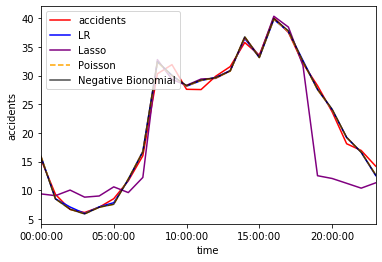

In [90]:
#Plot the mean of values of grouped hour verses grouped hour from each of the regressions
_ = accident_volume_df.loc[y2_test.index].groupby('time').mean().accidents.plot(c='r')
_ = m2_predict_dow.groupby('time').mean().predicted.plot(c='blue', label='LR')
_ = m3_predict_dow.groupby('time').mean().predicted.plot(c='purple', label='Lasso')
_ = m4_predict_dow.groupby('time').mean().predicted.plot(c='orange', linestyle='--', label='Poisson')
_ = m5_predict_dow.groupby('time').mean().predicted.plot(c='black', alpha=0.7, label='Negative Bionomial')
plt.ylabel('accidents')
plt.legend(loc='upper left')
plt.savefig('compare_average.png')

End of notebook